# Intravoxel incoherent motion (IVIM) imaging

In [1]:
import matplotlib.pyplot as plt
from dipy.reconst.ivim import IvimModel
from dipy.data.fetcher import read_ivim

/home/rutger/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
img, gtab = read_ivim()

Dataset is already in place. If you want to fetch it again please first remove the folder /home/rutger/.dipy/ivim 


In [3]:
gtab.big_delta

In [4]:
data = img.get_data()
print('data.shape (%d, %d, %d, %d)' % data.shape)
z = 33
x1, x2 = 90, 155
y1, y2 = 90, 170
data_slice = data[x1:x2, y1:y2, z, :]

data.shape (256, 256, 54, 21)


In [16]:
ivimmodel = IvimModel(gtab)
ivimfit = ivimmodel.fit(data_slice)

/home/rutger/anaconda2/lib/python2.7/site-packages/dipy-0.13.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:404: UserWarning: x0 obtained from linear fitting is not feasibile as initial guess for leastsq while estimating f and D_star. Using parameters from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/home/rutger/anaconda2/lib/python2.7/site-packages/dipy-0.13.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:498: UserWarning: x0 is unfeasible for leastsq fitting. Returning x0 values from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/home/rutger/anaconda2/lib/python2.7/site-packages/dipy-0.13.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:293: UserWarning: Bounds are violated for leastsq fitting. Returning parameters from linear fit
  warnings.warn(warningMsg, UserWarning)


In [26]:
ivimfit.perfusion_fraction

array([[ 0.3       ,  0.3       ,  0.3       , ...,  0.10228682,
         0.08836809,  0.3       ],
       [ 0.3       ,  0.3       ,  0.3       , ...,  0.07622593,
         0.09480977,  0.08430158],
       [ 0.3       ,  0.3       ,  0.3       , ...,  0.3       ,
         0.02210754,  0.07937667],
       ...,
       [ 0.09430396,  0.3       ,  0.3       , ...,  0.3       ,
         0.02933414,  0.07644474],
       [ 0.08382624,  0.3       ,  0.3       , ...,  0.29999136,
         0.29999994,  0.04675601],
       [ 0.3       ,  0.3       ,  0.3       , ...,  0.3       ,
         0.29999998, -0.00702222]])

In [4]:
from dmipy.signal_models import gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.core.acquisition_scheme import gtab_dipy2dmipy, acquisition_scheme_from_bvalues


In [11]:
scheme_ivim = gtab_dipy2dmipy(gtab, dummy_deltas=True, b0_threshold=1e6, min_b_shell_distance=1e6)
scheme_ivim.print_acquisition_info

Acquisition scheme summary

total number of measurements: 21
number of b0 measurements: 1
number of DWI shells: 20

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |0                        |10.0       |30.0      |N/A  
1           |1         |10              |7                        |10.0       |30.0      |N/A  
2           |1         |20              |10                       |10.0       |30.0      |N/A  
3           |1         |30              |12                       |10.0       |30.0      |N/A  
4           |1         |40              |14                       |10.0       |30.0      |N/A  
5           |1         |60              |17                       |10.0       |30.0      |N/A  
6           |1         |80              |20                       |10.0       |30.0      |N/A  
7           |1         |100             |22                       |10.0       |30.0      |N/A  
8           |1     

In [12]:
ball1 = gaussian_models.G1Ball()
ball2 = gaussian_models.G1Ball()
ivim_mod = MultiCompartmentModel([ball1, ball2])

In [13]:
ivim_mod.parameter_ranges['G1Ball_1_lambda_iso'] = (3, 20)

In [14]:
ivim_mod.parameter_ranges

OrderedDict([('G1Ball_1_lambda_iso', (3, 20)),
             ('G1Ball_2_lambda_iso', (0.1, 3)),
             ('partial_volume_0', (0.01, 0.99)),
             ('partial_volume_1', (0.01, 0.99))])

In [15]:
ivim_fit = ivim_mod.fit(scheme_ivim, data_slice, mask=data_slice[..., 0] > 0, solver='mix', Ns=20)

Using parallel processing with 8 workers.
Setup MIX optimizer in 8.01086425781e-05 seconds
COBYLA failed to find a solution: Maximum number of function evaluations has been exceeded.
COBYLA failed to find a solution: Maximum number of function evaluations has been exceeded.
Fitting of 5200 voxels complete in 345.635720015 seconds.
Average of 0.0664684076951 seconds per voxel.


In [28]:
ivim_fit.fitted_parameters.keys()

['partial_volume_1',
 'partial_volume_0',
 'G1Ball_1_lambda_iso',
 'G1Ball_2_lambda_iso']

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
ivimfit.D_star.min()

-0.0008422857361330238

In [43]:
ivimfit.D_star.max()

0.9999999999999999

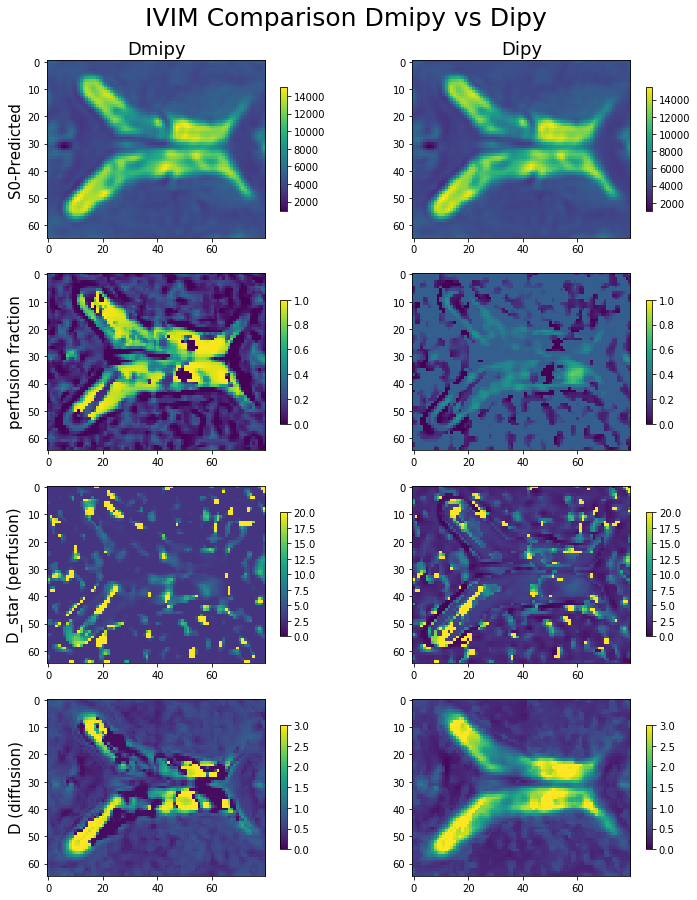

In [74]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=[12, 15])
fig.suptitle('IVIM Comparison Dmipy vs Dipy', fontsize=25, y=0.93)
axs = axs.ravel()
axs[0].set_title('Dmipy', fontsize=18)
axs[1].set_title('Dipy', fontsize=18)
axs[0].set_ylabel('S0-Predicted', fontsize=15)
axs[2].set_ylabel('perfusion fraction', fontsize=15)
axs[4].set_ylabel('D_star (perfusion)', fontsize=15)
axs[6].set_ylabel('D (diffusion)', fontsize=15)

im = axs[0].imshow(ivim_fit.S0)
fig.colorbar(im, ax=axs[0], shrink=0.7)
im = axs[1].imshow(ivimfit.S0_predicted)
fig.colorbar(im, ax=axs[1], shrink=0.7)
im = axs[2].imshow(ivim_fit.fitted_parameters['partial_volume_0'], vmin=0., vmax=1.)
fig.colorbar(im, ax=axs[2], shrink=0.7)
im = axs[3].imshow(ivimfit.perfusion_fraction, vmin=0., vmax=1.)
fig.colorbar(im, ax=axs[3], shrink=0.7)
im = axs[4].imshow(ivim_fit.fitted_parameters['G1Ball_1_lambda_iso'] * 1e9, vmin=0, vmax=20)
fig.colorbar(im, ax=axs[4], shrink=0.7)
im = axs[5].imshow(ivimfit.D_star * 1e3, vmin=0, vmax=20)
fig.colorbar(im, ax=axs[5], shrink=0.7)
im = axs[6].imshow(ivim_fit.fitted_parameters['G1Ball_2_lambda_iso'] * 1e9, vmin=0., vmax=3)
fig.colorbar(im, ax=axs[6], shrink=0.7)
im = axs[7].imshow(ivimfit.D * 1e3, vmin=0., vmax=3)
fig.colorbar(im, ax=axs[7], shrink=0.7)

Dmipy does not split the data, Dipy does.

What is physically correct in IVIM?

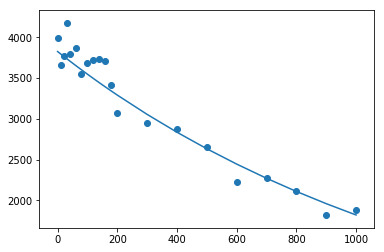

In [31]:
plt.plot(gtab.bvals, ivim_fit.predict()[10, 10])
plt.scatter(gtab.bvals, data_slice[10, 10])